<a href="https://colab.research.google.com/github/umbertodicanito/Stochastic-Training-of-Graph-Convolutional-Networks-with-Variance-Reduction/blob/master/PubMed_GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

#Imports

In [0]:
!pip install dgl

     |████████████████████████████████| 2.4MB 2.6MB/s 


In [0]:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from dgl import DGLGraph
from google.colab import files
import warnings
import matplotlib.pyplot as plt

gcn_msg = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

#Building matrices for algorithm 1 execution

In [0]:
from dgl.data import citation_graph as citegrh
import networkx as nx
def load_pubmed_data():
    data = citegrh.load_pubmed()
    features = th.FloatTensor(data.features)
    labels = th.LongTensor(data.labels)
    mask = th.ByteTensor(data.train_mask)
    g = data.graph
    print(g)
    # add self loop
    g.remove_edges_from(nx.selfloop_edges(g))
    g = DGLGraph(g)
    g.add_edges(g.nodes(), g.nodes())
    return g, features, labels, mask
    
#get data
g, features, labels, mask = load_pubmed_data()

Extracting file to /root/.dgl/pubmed
Finished data loading and preprocessing.
  NumNodes: 19717
  NumEdges: 88651
  NumFeats: 500
  NumClasses: 3
  NumTrainingSamples: 60
  NumValidationSamples: 500
  NumTestSamples: 1000



`deg_matrix` is the diagonal degree matrix.
This means that the degree of a node `'v'` with value `'d'`, is stored at `D[u][u]=d`, whereas all the other values of the matrix (except the diagonal) are equal to 0.

In [0]:
def createMatrixP():
  import math
  deg_matrix = th.tensor(np.zeros((19717,19717)))
  print("Constructing the degree matrix...")
  for i in range(19717):
    d = len(g.adjacency_matrix()[i]._indices()[0])
    deg_matrix[i][i] = math.pow(d,-0.5)

  print("Computing matrix P...")
  p = th.mm(th.mm(deg_matrix.float(),g.adjacency_matrix().to_dense().float()),deg_matrix.float())
  print("Matrix P has shape of:")
  print(p.shape)
  return p

This is the propagation matrix P

In [0]:
P = createMatrixP()

Constructing the degree matrix...


/usr/local/lib/python3.6/dist-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


Computing matrix P...
Matrix P has shape of:
torch.Size([19717, 19717])


The object `g` allows us to get more easily the neighboors nodes.


In [0]:
warnings.filterwarnings('ignore')
r = random.randint(0,19716)
print("Node " + str(r))
g.adjacency_matrix()[r]._indices()[0]

Node 17222


tensor([ 7712, 15025, 16747, 17222])

In [0]:
a = list(g.adjacency_matrix()[r]._indices()[0].numpy())
a.remove(r)
print(type(a))
print(a)

<class 'list'>
[7712, 15025, 16747]


This is a simple method used to transforma a list into a torch.Tensor object corresponding to a mask.

In [0]:
def createMask(array):
  a = []
  for i in range(19717):
    if i in array:
      a.append(1)
    else:
      a.append(0)
  m = th.ByteTensor(a)
  return m

In [0]:
plain_deg_matrix = np.zeros(19717)
for i in range(19717):
  d = len(g.adjacency_matrix()[i]._indices()[0])
  plain_deg_matrix[i] = d

/usr/local/lib/python3.6/dist-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


#Implementing algorithm 1

The following algorithm is used in order to retrive the receptive fields of each layer and the propagation matrices for each layer, just for the selected minibath of nodes.

The algorithm is used in algorithm for training with CV and CVD approaches.

Pseudo-code:



```
r_L = V_B
for layer l = L - 1 to 0 do
  r_l = 0
  P'_l = 0
  for each node u in r_l+1 do
    r_l = r_l + {u}
    P'_uu^l = P'_uu^l + P_uu*n(u)/D_l
    for D_l - 1 random neighbors v in n(u) do
      r_l = r_l + {v}
      P'_uv^l = P'_uv^l + P_uv*n(u)/D_l
    end for
  end for
end for
```
where


*   r_L: the receptive field of layer L
*   V_B: the minibatch set (a subset of nodes)
*   P'_l: propagation matrix of the layer l
*   P'_uv^l = P_uv^l * n(u)/D_l, if v is in n'(u)_l, otherwise 0
*   n(u): neighbors of u
*   n'(u): random subset of n(u)
*   D_l: neighbors for each node at layer l

Notice that, since we do not use MINIbatches, n(u)/D_l is always equal to 1.



In [0]:
import time
#implementation of the above algorithm#

#minibatch = th.ByteTensor(...) of 0,1 boolean (it is a mask)

#returning: the receptive fields and the propagation matrices
def algOne(minibatch):
  t0 = time.time()
  rL = minibatch
  l = 2
  n = 2

  receptiveField = dict()
  propagationMatrix = dict()

  receptiveField[l] = rL

  diffZero = dict()
  values = dict()

  #first for-loop
  while l > 0:
    #init
    field = []
    #second for-loop
    k = 0
    for nodeValue in receptiveField[l]:
      if nodeValue == 1:
        node = k

        if node not in field:
          field.append(node)

        toAdd = P[node][node] * plain_deg_matrix[node] / n

        if node not in diffZero:
          diffZero[node] = []
          values[node] = dict()
        if node not in diffZero[node]:
          diffZero[node].append(node)
          values[node][node] = 0
        
        values[node][node] = values[node][node] + toAdd

        #collecting n random neighbor
        subset = []
        a = list(g.adjacency_matrix()[node]._indices()[0].numpy())
        a.remove(node)
        if len(a) <= n:
          subset = a
        else:
          subset = random.sample(a, k=n)

        #last for-loop
        for neighbor in subset:
          if neighbor not in field:
            field.append(neighbor)

          toAddForNeighbor = P[node][neighbor] * plain_deg_matrix[node]/ n

          if neighbor not in diffZero[node]:
            diffZero[node].append(neighbor)
            values[node][neighbor] = 0
          values[node][neighbor] = values[node][neighbor] + toAddForNeighbor
      k = k + 1
      
    #updating level
    l = l - 1

    #convert field (array of nodes) to a mask
    receptiveField[l] = createMask(field).detach()

    #creating sparse matrix
    X = []
    Y = []
    V = []
    for x in diffZero:
      for y in diffZero[x]:
        X.append(x)
        Y.append(y)
        V.append(values[x][y])
      
    index = th.LongTensor([X,Y])
    valuesOfProp = th.FloatTensor(V)
    propagationMatrix[l] = th.sparse.FloatTensor(index, valuesOfProp, th.Size([19717,19717]))
  
  #print(time.time() - t0)
  return [receptiveField, propagationMatrix]

Testing algorithm one:

In [0]:
import time

t0 = time.time()
res = algOne(mask)
print(time.time()-t0)

/usr/local/lib/python3.6/dist-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


1.8744902610778809


#Model


Some commond parameters used to train the NN

In [0]:
n_of_training_cycles = 10
n_of_epochs = 65

This methods creates some random masks.

In [0]:
#random mask
masks = []
n_masks = 10
size_masks = 100
a = range(19717)
for i in range(n_masks):
  mask = np.zeros(19717)
  sub = random.sample(a,k=size_masks)
  for s in sub:
    mask[s] = 1
  m = th.ByteTensor(mask)
  masks.append(m)

print("Generated " + str(n_masks) + " random masks with size " + str(size_masks))

Generated 10 random masks with size 100


We then define the node UDF for ``apply_nodes``, which is a fully-connected layer:



In [0]:
class NodeApplyModule(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
        z = self.linear(node.data['h'])
        h = self.activation(z)
        return {'h' : h}

We then proceed to define the GCN module. A GCN layer essentially performs
message passing on all the nodes then applies the `NodeApplyModule`. Note
that we omitted the dropout in the paper for simplicity.



In [0]:
class GCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(GCN, self).__init__()
        self.apply_mod = NodeApplyModule(in_feats, out_feats, activation)

    def forward(self, g, feature):
        g.ndata['h'] = feature
        g.update_all(gcn_msg, gcn_reduce)
        g.apply_nodes(func=self.apply_mod)
        return g.ndata.pop('h')

The forward function is essentially the same as any other commonly seen NNs
model in PyTorch.  We can initialize GCN like any ``nn.Module``. For example,
let's define a simple neural network consisting of two GCN layers. Suppose we
are training the classifier for the PubMed dataset (the input feature size is
1433 and the number of classes is 7).



In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.gcn1 = GCN(500, 16, F.relu)
        self.gcn2 = GCN(16, 3, F.relu)

    def forward(self, g, features):
        x = self.gcn1(g, features)
        x = self.gcn2(g, x)
        return x
        
net = Net()
print(net)

Net(
  (gcn1): GCN(
    (apply_mod): NodeApplyModule(
      (linear): Linear(in_features=500, out_features=16, bias=True)
    )
  )
  (gcn2): GCN(
    (apply_mod): NodeApplyModule(
      (linear): Linear(in_features=16, out_features=3, bias=True)
    )
  )
)


We load the PubMed dataset using DGL's built-in data module.



We then train the network as follows:



This is the implementation of a standard GCN with 2 layers (+ 1 input layer). 

TEST --------------------------------------

In order to get the most effective learning rate for the CiteSeer set, running these cells multiple times will show comparison of performance between 4 different learning rates.

In [0]:
lrAccTest = dict()
lrLossTest = dict()

In [0]:
def updatePoints(index,accCS,lossCS, acc, loss):
  accPointsTest = [0]*30
  lossPointsTest = [0]*30

  for d in range(3):
    for i in range(30):
      accPointsTest[i] = accPointsTest[i] + accCS[d][i]
      lossPointsTest[i] = lossPointsTest[i] + lossCS[d][i]

  for i in range(30):
    accPointsTest[i] = accPointsTest[i]/3
    lossPointsTest[i] = lossPointsTest[i]/3
  
  acc[index] = accPointsTest
  loss[index] = lossPointsTest
  return [acc,loss]

In [0]:
import time
import collections
import numpy as np
warnings.filterwarnings('ignore')

#init counters
lrs = [1e-1, 1e-2, 1e-3, 1e-4]
for actualLR in lrs:
  testAccCS = []
  testLossCS = []
  for t in range(3):
    print("Starting new training")
    #get data from DGL
    net = Net()
    g, features, labels, mask = load_pubmed_data()
    print(g)

    #point to show on graph
    pointsPubMed=dict()
    pointsLossPubMed=dict()

    #the number of masks to get when training per epoch
    n_masks_to_try = 4
    #initializing the optimizer (optimizer takes care of optimize the learining rate during training)
    optimizer = th.optim.Adam(net.parameters(), lr=actualLR)
    optimizer.state = collections.defaultdict(dict)

    #dur is just an array to store the duration in order to show them later
    dur = []

    for epoch in range(30):
        t0 = time.time()

        #getting only some masks (4)
        masksToTry = random.sample(masks,n_masks_to_try)

        for m in masksToTry:
            #calling 'net(...)' it asks to the GCN to compute the forward    

            logits = net(g, features)
            logp = F.log_softmax(logits, 1)

            #compute loss like the negative log likelihood loss
            loss = F.nll_loss(logp[m], labels[m])
            
            #Since the backward() function accumulates gradients, and you 
            #don’t want to mix up gradients between minibatch, you have 
            #to zero them out at the start of a new minibatch. This is 
            #exactly like how a general (additive) accumulator variable is 
            #initialized to 0 in code.
            optimizer.zero_grad()

            #update network weights by loss
            loss.backward()

            #update optimizer's values after backward
            optimizer.step()

            #computing accuracy
            i = 0
            matched = 0
            while i < 19717:
              if m[i] == 0:
                #getting index of the maximum
                j = 0
                max = None
                jMax = 0
                for a in logp[i]:
                  if max==None:
                    max = a.item()
                    jMax = j
                  elif max < a.item():
                    max = a.item()
                    jMax = j
                  j = j + 1
                if jMax == labels[i]:
                  matched = matched + 1
              i = i + 1
            acc = matched/(19717-size_masks)*100

            if epoch not in pointsPubMed:
              pointsPubMed[epoch] = 0
              pointsLossPubMed[epoch] = 0
            pointsPubMed[epoch] = pointsPubMed[epoch] + acc
            pointsLossPubMed[epoch] = pointsLossPubMed[epoch] + loss.item()
            
        dur.append(time.time() - t0)
        
        #computing the average of the accuracy and the loss
        pointsPubMed[epoch] = pointsPubMed[epoch]/n_masks_to_try
        pointsLossPubMed[epoch] = pointsLossPubMed[epoch]/n_masks_to_try

        print("Epoch {:05d} | Loss {:.4f} | Time(s) {:.4f} | Accuracy: {:.6f} %".format(
                epoch, loss.item(), np.mean(dur), pointsPubMed[epoch]))
    #storing results    
    testAccCS.append(pointsPubMed)
    testLossCS.append(pointsLossPubMed)
    print("Results stored.")
  print("New learning rate...")
  r = updatePoints(actualLR,testAccCS,testLossCS, lrAccTest, lrLossTest)
  lrAccTest = r[0]
  lrLossTest = r[1]


Starting new training
Finished data loading and preprocessing.
  NumNodes: 19717
  NumEdges: 88651
  NumFeats: 500
  NumClasses: 3
  NumTrainingSamples: 60
  NumValidationSamples: 500
  NumTestSamples: 1000

DGLGraph(num_nodes=19717, num_edges=108365,
         ndata_schemes={}
         edata_schemes={})
Epoch 00000 | Loss 1.0686 | Time(s) 5.5194 | Accuracy: 39.114034 %
Epoch 00001 | Loss 1.0986 | Time(s) 5.5088 | Accuracy: 21.524698 %
Epoch 00002 | Loss 1.0986 | Time(s) 5.4561 | Accuracy: 20.809757 %
Epoch 00003 | Loss 1.0986 | Time(s) 5.4125 | Accuracy: 20.817403 %
Epoch 00004 | Loss 1.0986 | Time(s) 5.3876 | Accuracy: 20.814854 %
Epoch 00005 | Loss 1.0986 | Time(s) 5.3926 | Accuracy: 20.813580 %
Epoch 00006 | Loss 1.0986 | Time(s) 5.3820 | Accuracy: 20.813580 %
Epoch 00007 | Loss 1.0986 | Time(s) 5.3848 | Accuracy: 20.816129 %
Epoch 00008 | Loss 1.0986 | Time(s) 5.3796 | Accuracy: 20.812306 %
Epoch 00009 | Loss 1.0986 | Time(s) 5.3833 | Accuracy: 20.814854 %
Epoch 00010 | Loss 1.0986

In [0]:
axisX = range(30)
colors = dict()
#lrs = [1e-1, 1e-2, 1e-3, 1e-4]
colors[1e-1] = "red"
colors[1e-2] = "orange"
colors[1e-3] = "blue"
colors[1e-4] = "green"

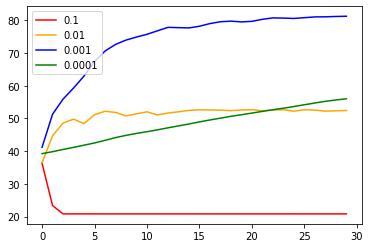

In [0]:
for lr in lrs:
  plt.plot(axisX, lrAccTest[lr], color = colors[lr], label=str(lr))
plt.legend()
plt.show()

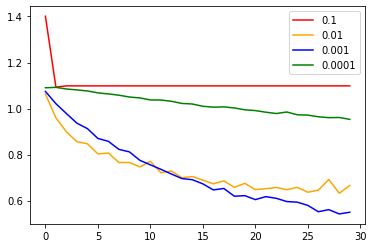

In [0]:
for lr in lrs:
  plt.plot(axisX, lrLossTest[lr], color = colors[lr], label=str(lr))
plt.legend()
plt.show()

TEST ^^^^^^^^^^^^^^^^^^^^^^^^^

In [0]:
import time
import collections
import numpy as np
warnings.filterwarnings('ignore')

#init counters
averageAccPubMed = []
averageLossPubMed = []

for t in range(n_of_training_cycles):
  print("Starting new training")
  #get data from DGL
  net = Net()
  g, features, labels, mask = load_pubmed_data()
  print(g)

  #point to show on graph
  pointsPubMed=dict()
  pointsLossPubMed=dict()

  #the number of masks to get when training per epoch
  n_masks_to_try = 4
  #initializing the optimizer (optimizer takes care of optimize the learining rate during training)
  optimizer = th.optim.Adam(net.parameters(), lr=2e-3)
  optimizer.state = collections.defaultdict(dict)

  #dur is just an array to store the duration in order to show them later
  dur = []

  #this 'for' cycles on 200 epochs
  for epoch in range(n_of_epochs):
      t0 = time.time()

      #getting only some masks (4)
      masksToTry = random.sample(masks,n_masks_to_try)

      for m in masksToTry:
          #calling 'net(...)' it asks to the GCN to compute the forward    

          logits = net(g, features)
          logp = F.log_softmax(logits, 1)

          #compute loss like the negative log likelihood loss
          loss = F.nll_loss(logp[m], labels[m])
          
          #Since the backward() function accumulates gradients, and you 
          #don’t want to mix up gradients between minibatch, you have 
          #to zero them out at the start of a new minibatch. This is 
          #exactly like how a general (additive) accumulator variable is 
          #initialized to 0 in code.
          optimizer.zero_grad()

          #update network weights by loss
          loss.backward()

          #update optimizer's values after backward
          optimizer.step()

          #computing accuracy
          i = 0
          matched = 0
          while i < 19717:
            if m[i] == 0:
              #getting index of the maximum
              j = 0
              max = None
              jMax = 0
              for a in logp[i]:
                if max==None:
                  max = a.item()
                  jMax = j
                elif max < a.item():
                  max = a.item()
                  jMax = j
                j = j + 1
              if jMax == labels[i]:
                matched = matched + 1
            i = i + 1
          acc = matched/(19717-size_masks)*100

          if epoch not in pointsPubMed:
            pointsPubMed[epoch] = 0
            pointsLossPubMed[epoch] = 0
          pointsPubMed[epoch] = pointsPubMed[epoch] + acc
          pointsLossPubMed[epoch] = pointsLossPubMed[epoch] + loss.item()
          
      dur.append(time.time() - t0)
      
      #computing the average of the accuracy and the loss
      pointsPubMed[epoch] = pointsPubMed[epoch]/n_masks_to_try
      pointsLossPubMed[epoch] = pointsLossPubMed[epoch]/n_masks_to_try

      print("Epoch {:05d} | Loss {:.4f} | Time(s) {:.4f} | Accuracy: {:.6f} %".format(
              epoch, loss.item(), np.mean(dur), pointsPubMed[epoch]))
  #storing results    
  averageAccPubMed.append(pointsPubMed)
  averageLossPubMed.append(pointsLossPubMed)
  print("Results stored.")

Starting new training
Finished data loading and preprocessing.
  NumNodes: 19717
  NumEdges: 88651
  NumFeats: 500
  NumClasses: 3
  NumTrainingSamples: 60
  NumValidationSamples: 500
  NumTestSamples: 1000

DGLGraph(num_nodes=19717, num_edges=108365,
         ndata_schemes={}
         edata_schemes={})
Epoch 00000 | Loss 1.0122 | Time(s) 5.4713 | Accuracy: 44.661518 %
Epoch 00001 | Loss 0.9039 | Time(s) 5.4781 | Accuracy: 50.350461 %
Epoch 00002 | Loss 0.8905 | Time(s) 5.4659 | Accuracy: 56.586124 %
Epoch 00003 | Loss 0.7999 | Time(s) 5.4654 | Accuracy: 61.882551 %
Epoch 00004 | Loss 0.7733 | Time(s) 5.4543 | Accuracy: 65.589795 %
Epoch 00005 | Loss 0.7454 | Time(s) 5.4639 | Accuracy: 67.989499 %
Epoch 00006 | Loss 0.7854 | Time(s) 5.4647 | Accuracy: 69.048529 %
Epoch 00007 | Loss 0.6895 | Time(s) 5.4849 | Accuracy: 71.945252 %
Epoch 00008 | Loss 0.7206 | Time(s) 5.4777 | Accuracy: 75.039507 %
Epoch 00009 | Loss 0.6326 | Time(s) 5.4781 | Accuracy: 73.919305 %
Epoch 00010 | Loss 0.6149

#On graphic

In [0]:
accPointsPubMed = [0]*n_of_epochs
lossPointsPubMed = [0]*n_of_epochs

for d in range(n_of_training_cycles):
  for i in range(n_of_epochs):
    accPointsPubMed[i] = accPointsPubMed[i] + averageAccPubMed[d][i]
    lossPointsPubMed[i] = lossPointsPubMed[i] + averageLossPubMed[d][i]

for i in range(n_of_epochs):
  accPointsPubMed[i] = accPointsPubMed[i]/n_of_training_cycles
  lossPointsPubMed[i] = lossPointsPubMed[i]/n_of_training_cycles

In [0]:
maxAccPubMed = np.argmax(accPointsPubMed)
maxAccPubMed

35

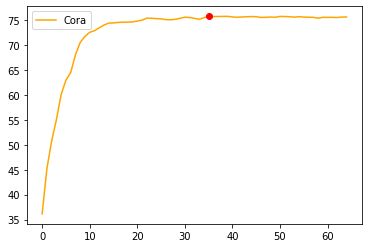

In [0]:
axisX = range(n_of_epochs)

plt.plot(axisX, accPointsPubMed, color='orange', label='PubMed')
#plt.plot(axisX, pointsPubMed, color='blue', label='PubMed')
plt.plot([maxAccPubMed], accPointsPubMed[maxAccPubMed], marker='o', color='red')
#plt.plot([maxAccPubMed], pointsPubMed[maxAccPubMed], marker='o', color='blue')
plt.legend()
plt.show()

In [0]:
print("Max accuracy PubMed at {:03d} epochs with value {:05f}"
  .format(maxAccPubMed, pointsPubMed[maxAccPubMed]))
#print("Max accuracy PubMed at {:03d} epochs with value {:05f}"
#  .format(maxAccPubMed, pointsPubMed[maxAccPubMed]))

Max accuracy Cora at 035 epochs with value 81.955702


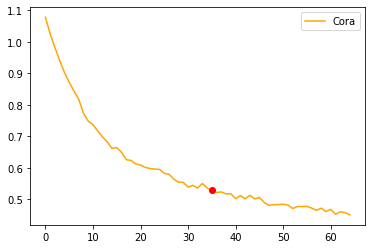

In [0]:
plt.plot(axisX, lossPointsPubMed, color='orange', label='PubMed')
#plt.plot(axisX, pointsLossPubMed, color='blue', label='PubMed')
plt.plot([maxAccPubMed], lossPointsPubMed[maxAccPubMed], marker='o', color='red')
#plt.plot([maxAccPubMed], pointsLossPubMed[maxAccPubMed].item(), marker='o',color='blue')
plt.legend()
plt.show()

In [0]:
print("For PubMed, at epoch {:03d}, loss was {:05f}"
  .format(maxAccPubMed, lossPointsPubMed[maxAccPubMed]))
#print("For PubMed, at epoch {:03d}, loss was {:05f}"
#  .format(maxAccPubMed, pointsLossPubMed[maxAccPubMed]))

For Cora, at epoch 035, loss was 0.529607


#Our algorithm

For our algorithm we need to store somewhere some information. In particular for each training cycle we will update the historical activation in order to bring an efficent approximation. Also, we need to store the last recent h_0 and h_1, for computational purpose.

In [0]:
class HMatrices():
  def __init__(self):
    self.historical_activation_1 = th.Tensor(np.zeros((19717,500)))
    self.historical_activation_2 = th.Tensor(np.zeros((19717,16)))
    self.h_0 = th.Tensor([])
    self.h_1 = th.Tensor([])

  def updateHMatrix(self,features,x):
    self.h_0 = features
    self.h_1 = x
  
  def updateActivation(self, row, level, a):
    if level == 0:
      self.historical_activation_1[row] = a
    elif level == 1:
      self.historical_activation_2[row] = a

In [0]:
class SimpleNodeApplyModule(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(SimpleNodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
        #type of node: dgl.udf.NodeBatch
        #type of node.data['h']: torch.Tensor
        z = self.linear(node.data['h'])
        h = self.activation(z)
        return {'h' : h}

In [0]:
class SimpleGCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(SimpleGCN, self).__init__()
        self.apply_mod = SimpleNodeApplyModule(in_feats, out_feats, activation)

    def forward(self, g, feature):
        g.ndata['h'] = feature
        g.update_all(gcn_msg, gcn_reduce)
        g.apply_nodes(func=self.apply_mod)
        return g.ndata.pop('h')

In [0]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.gcn1 = SimpleGCN(500, 16, F.relu)
        self.gcn2 = SimpleGCN(16, 3, F.relu)

    def forward(self, g, features, propMatrix, historicalActivation, hContainer):
        #type of 'g': dgl.graph.DGLGraph
        x = self.gcn1(g, features)
        hContainer.updateHMatrix(features, x)
        # CV = (P'_l*(H_l-H'_l)+P*H'_l)
        x = th.mm(propMatrix,x.sub(historicalActivation)).add(th.mm(P,historicalActivation))
        x = self.gcn2(g, x)
        return x

simpleNet = SimpleNet()
print(simpleNet)

SimpleNet(
  (gcn1): SimpleGCN(
    (apply_mod): SimpleNodeApplyModule(
      (linear): Linear(in_features=500, out_features=16, bias=True)
    )
  )
  (gcn2): SimpleGCN(
    (apply_mod): SimpleNodeApplyModule(
      (linear): Linear(in_features=16, out_features=3, bias=True)
    )
  )
)


In [0]:
import time
import collections
import numpy as np
warnings.filterwarnings('ignore')

#init counters
averageAccPubMed_our = []
averageLossPubMed_our = []
#
n_of_training_cycles = 1
#
for t in range(n_of_training_cycles):
  print("Starting new training cycle")

  simpleNet = SimpleNet()
  #point to show on graph
  pointsOurPubMed=dict()
  pointsOurLossPubMed=dict()

  with th.no_grad():
    #get data
    g, features, labels, mask = load_pubmed_data()

    print(g)
    n_masks_to_try = 4
    ourOptimizer = th.optim.Adam(simpleNet.parameters(), lr=2e-3)
    ourOptimizer.state = collections.defaultdict(dict)
    dur = []

    #running algOne for each mask
    t0 = time.time()
    print("Computing algorithm 1 for each mask...")
    resForMasks = dict()
    for m in masks:
      resForMasks[m] = algOne(m)
    print("{:03f} seconds".format(time.time()-t0))

  #this is an object storing some constant data
  hs = HMatrices()

  for epoch in range(n_of_epochs):
        
      t0 = time.time()
      #getting only some masks (4)
      masksToTry = random.sample(masks,n_masks_to_try)
      for m in masksToTry:
          #calling 'net(...)' it asks to the GCN to compute the forward

          #M=(P'_l*(H_l-H'_l)+P*H'_l)
          #H_l = feature
          #P': progationMatrix
          #H': get from initialized matrix
          #P: computed before
          CV = th.mm(resForMasks[m][1][0].to_dense(),features.sub(hs.historical_activation_1.detach())).add(th.mm(P,hs.historical_activation_1.detach()))
          logits = simpleNet(g, CV, resForMasks[m][1][1].to_dense(), hs.historical_activation_2.detach(), hs)
          logp = F.log_softmax(logits, 1)

          #compute loss like the negative log likelihood loss
          ourLoss = F.nll_loss(logp[m], labels[m])

          #Since the backward() function accumulates gradients, and you 
          #don’t want to mix up gradients between minibatch, you have 
          #to zero them out at the start of a new minibatch. This is 
          #exactly like how a general (additive) accumulator variable is 
          #initialized to 0 in code.
          ourOptimizer.zero_grad()

          #update network weights by loss
          #ourLoss.backward(retain_graph=True)
          ourLoss.backward()

          #update optimizer's values after backward
          ourOptimizer.step()

          #computing accuracy
          i = 0
          matched = 0
          while i < 19717:
            if m[i] == 0:
              #getting index of the maximum
              j = 0
              max = None
              jMax = 0
              for a in logp[i]:
                if max==None:
                  max = a.item()
                  jMax = j
                elif max < a.item():
                  max = a.item()
                  jMax = j
                j = j + 1
              if jMax == labels[i]:
                matched = matched + 1
            i = i + 1
          acc = matched/(19717-size_masks)*100

          if epoch not in pointsOurPubMed:
            pointsOurPubMed[epoch] = 0
            pointsOurLossPubMed[epoch] = 0
          pointsOurPubMed[epoch] = pointsOurPubMed[epoch] + acc
          pointsOurLossPubMed[epoch] = pointsOurLossPubMed[epoch] + ourLoss.item()
          
          #update historical activation
          for i in range(2):
            recField = resForMasks[m][0][i]
            k = 0
            if i == 0:
              for n in recField:
                if n == 1:
                  hs.updateActivation(k,i,hs.h_0[k])
                k = k + 1
            elif i == 1:
              for n in recField:
                if n == 1:
                  hs.updateActivation(k,i,hs.h_1[k])
                k = k + 1

      dur.append(time.time() - t0)
      
      pointsOurPubMed[epoch] = pointsOurPubMed[epoch]/n_masks_to_try
      pointsOurLossPubMed[epoch] = pointsOurLossPubMed[epoch]/n_masks_to_try

      print("Epoch {:05d} | Loss {:.4f} | Time(s) {:.4f} | Accuracy: {:.6f}".format(
              epoch, ourLoss.item(), np.mean(dur), pointsOurPubMed[epoch]))
  
  averageAccPubMed_our.append(pointsOurPubMed)
  averageLossPubMed_our.append(pointsOurLossPubMed)
  print("Results stored")

Starting new training cycle
Finished data loading and preprocessing.
  NumNodes: 19717
  NumEdges: 88651
  NumFeats: 500
  NumClasses: 3
  NumTrainingSamples: 60
  NumValidationSamples: 500
  NumTestSamples: 1000

DGLGraph(num_nodes=19717, num_edges=108365,
         ndata_schemes={}
         edata_schemes={})
Computing algorithm 1 for each mask...
23.862541 seconds
Epoch 00000 | Loss 1.1034 | Time(s) 39.9669 | Accuracy: 20.807208
Epoch 00001 | Loss 1.0968 | Time(s) 39.7660 | Accuracy: 21.003466
Epoch 00002 | Loss 1.0937 | Time(s) 39.7898 | Accuracy: 21.924861
Epoch 00003 | Loss 1.0804 | Time(s) 39.7343 | Accuracy: 23.731967
Epoch 00004 | Loss 1.0723 | Time(s) 39.6922 | Accuracy: 27.588316
Epoch 00005 | Loss 1.0602 | Time(s) 39.6738 | Accuracy: 33.832900
Epoch 00006 | Loss 1.0180 | Time(s) 39.6227 | Accuracy: 39.084722
Epoch 00007 | Loss 0.9964 | Time(s) 39.6646 | Accuracy: 44.082938
Epoch 00008 | Loss 1.0361 | Time(s) 39.6958 | Accuracy: 49.049294
Epoch 00009 | Loss 0.9179 | Time(s) 39

#On graphic (our algorithm)

In [0]:
accPointsPubMed_our = [0]*n_of_epochs
lossPointsPubMed_our = [0]*n_of_epochs

for d in range(n_of_training_cycles):
  for i in range(n_of_epochs):
    accPointsPubMed_our[i] = accPointsPubMed_our[i] + averageAccPubMed_our[d][i]
    lossPointsPubMed_our[i] = lossPointsPubMed_our[i] + averageLossPubMed_our[d][i]

for i in range(n_of_epochs):
  accPointsPubMed_our[i] = accPointsPubMed_our[i]/n_of_training_cycles
  lossPointsPubMed_our[i] = lossPointsPubMed_our[i]/n_of_training_cycles

In [0]:
maxAccPubMed_our = np.argmax(accPointsPubMed_our)
maxAccPubMed_our

32

Accuracy of our algorithm

In [0]:
axisX = range(n_of_epochs)

plt.plot(axisX, accPointsPubMed_our, color='orange', label='PubMed')
#plt.plot(axisX, pointsPubMed, color='blue', label='PubMed')
plt.plot([maxAccPubMed_our], accPointsPubMed_our[maxAccPubMed_our], marker='o', color='red')
#plt.plot([maxAccPubMed], pointsPubMed[maxAccPubMed], marker='o', color='blue')
plt.legend()
plt.show()

In [0]:
print("Max accuracy PubMed at {:03d} epochs with value {:05f}"
  .format(maxAccPubMed_our, accPointsPubMed_our[maxAccPubMed_our]))
#print("Max accuracy PubMed at {:03d} epochs with value {:05f}"
#  .format(maxAccPubMed, pointsPubMed[maxAccPubMed]))

Max accuracy Cora at 032 epochs with value 75.314778


Loss values of our algorithm

In [0]:
plt.plot(axisX, lossPointsPubMed_our, color='orange', label='PubMed')
#plt.plot(axisX, pointsLossPubMed, color='blue', label='PubMed')
plt.plot([maxAccPubMed_our], lossPointsPubMed_our[maxAccPubMed_our], marker='o', color='red')
#plt.plot([maxAccPubMed], pointsLossPubMed[maxAccPubMed].item(), marker='o',color='blue')
plt.legend()
plt.show()

In [0]:
print("For PubMed, at epoch {:03d}, loss was {:05f}"
  .format(maxAccPubMed_our, lossPointsPubMed_our[maxAccPubMed_our]))
#print("For PubMed, at epoch {:03d}, loss was {:05f}"
#  .format(maxAccPubMed, pointsLossPubMed[maxAccPubMed]))

For Cora, at epoch 032, loss was 0.569470


#Comparison

Comparison between accuracy of both algorithms. The red dots show the maximum values reached.

In [0]:
plt.plot(axisX, accPointsPubMed, color='orange', label='PubMed')
plt.plot(axisX, accPointsPubMed_our, color='blue', label='Our PubMed')
plt.plot([maxAccPubMed], accPointsPubMed[maxAccPubMed], marker='o', color ='red')
plt.plot([maxAccPubMed_our], accPointsPubMed_our[maxAccPubMed_our], marker='o', color='red')

plt.legend()
plt.show()

Comparison between the loss values of both algorithm. The red dots shows the loss values when the accuracy is at its maximum.

In [0]:
plt.plot(axisX, lossPointsPubMed, color='orange', label='PubMed')
plt.plot(axisX, lossPointsPubMed_our, color='blue', label='Our PubMed')
plt.plot([maxAccPubMed], lossPointsPubMed[maxAccPubMed], marker='o', color ='red')
plt.plot([maxAccPubMed_our], lossPointsPubMed_our[maxAccPubMed_our], marker='o', color='red')

plt.legend()
plt.show()